In [1277]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import os as os

path = "./results/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [1278]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                if t == 2: name = f"{path}/{alg}_{e}_{i}_t.npy"
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])


    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [1279]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

In [1280]:
def plot(ENVS, ALGORITHMS, curves):
    # Plotting Results
    for k, e in enumerate(ENVS):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e)  # Set environment name as the title
        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e]  # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue  # Skip if there's no data
            mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze()  # Smooth mean
            sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze()  # Smooth std deviation
            x = np.arange(mu.shape[0]) / 2 #modifed for represent the true number of episodes  # X-axis (time or episode count)
            
            ax.plot(x, mu, label=alg, linewidth=4, linestyle='--', color='C' + str(i))  # Plot mean curve
            ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i))  # Fill between std deviation
            ax.grid(True)  # Add grid
        
        ax.legend()  # Add legend for algorithms
        plt.show()  # Show the plot

Plots the performance curves for each algorithm on each environment.

No data for ExpD3 on MR-env. Skipping.


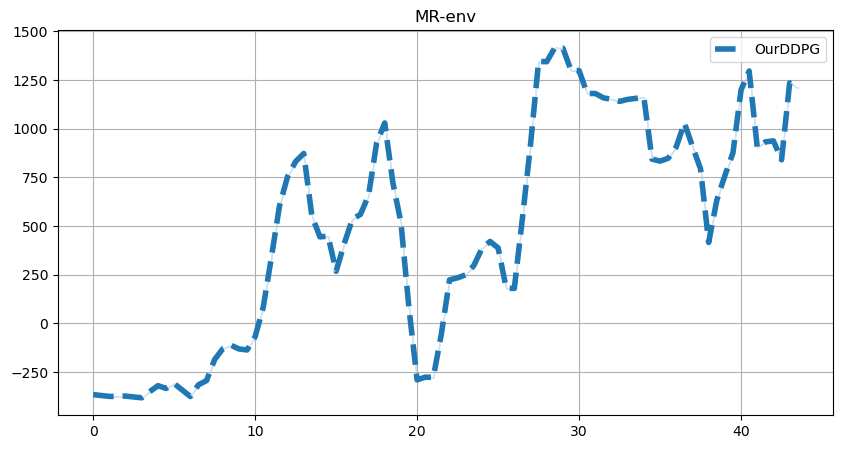

No data for OurDDPG on MR-corridor-env. Skipping.
No data for ExpD3 on MR-corridor-env. Skipping.


/tmp/ipykernel_9314/2574807345.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()  # Add legend for algorithms


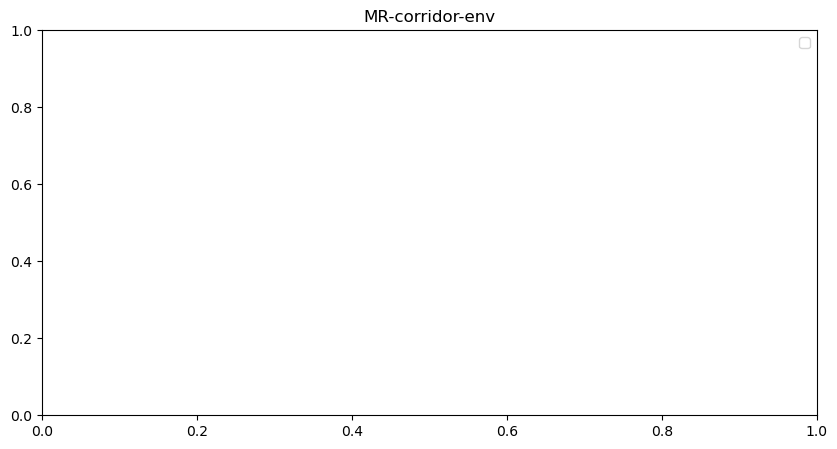

In [1281]:
# Define environments and algorithms
ENVS = ['MR-env', 'MR-corridor-env']
ALGORITHMS = ['OurDDPG', 'ExpD3']
done = 0

# Load the curves
curves = load_curves(ALGORITHMS, ENVS, done)

plot(ENVS,ALGORITHMS,curves)


No data for ExpD3 on MR-env. Skipping.


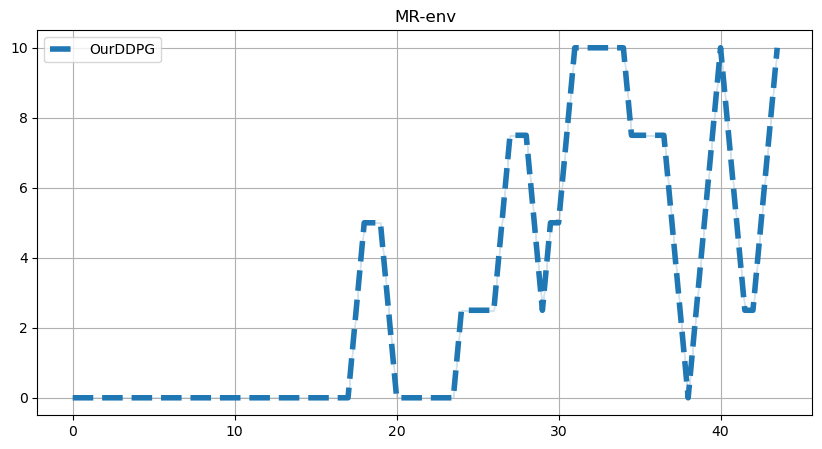

No data for OurDDPG on MR-corridor-env. Skipping.
No data for ExpD3 on MR-corridor-env. Skipping.


/tmp/ipykernel_9314/2574807345.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()  # Add legend for algorithms


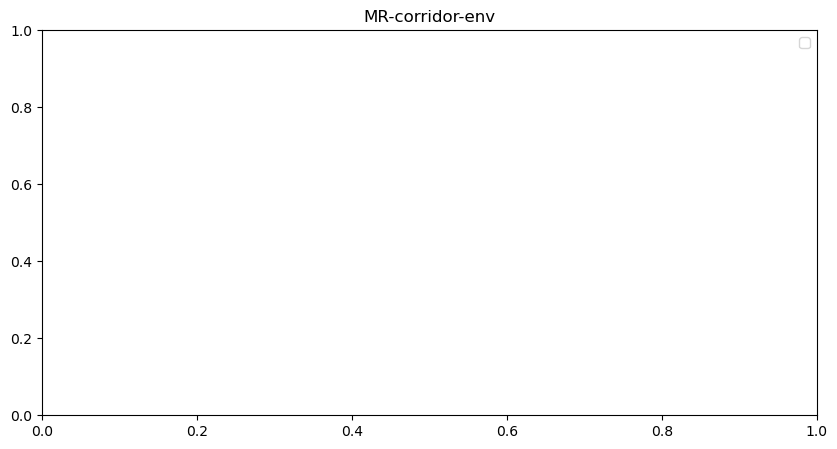

In [1282]:
done = 1
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, done)


plot(ENVS,ALGORITHMS,curves)

In [1283]:
s = np.load("./results/OurDDPG_MR-env_0_t.npy")

print(f"Percentage of success during training: {s*100:.3f} %")

Percentage of success during training: 44.724 %
